In [1]:
import pandas as pd
import numpy as np
import re
from matplotlib.ticker import MaxNLocator
import matplotlib.pyplot as plt
import seaborn as sns

# Overview of the data structure: 
Our main dataset [Dunnhumby - The complete journey](https://www.dunnhumby.com/careers/engineering/sourcefiles) comprises 8 csv files with the following tabular structure and content.

#### Campaign Desc
Description | Campaign ID | Start and End Day
--- | --- | ---
{TypeA, TypeB, TypeC} | int | int (probably day count from study)

#### Campaign Table
Description | Campaign ID | Household key
--- | --- | ---
{TypeA, TypeB, TypeC} | int | int

#### Casual Data
Product ID | Store ID | Week | Display location | Mailer location
--- | --- | --- | --- | --- 
int | int | int | int | String
 | | | Advertisement in in-store display? | Featured as ad in weekly mailer
 
#### Coupon Redemption
Household ID | Day | Coupon ID | Campaign ID 
--- | --- | --- | --- 
int | int | int | int 

#### Coupon
Coupon ID | Product ID | Campaign ID 
--- | --- | ---  
int | int | int 

#### Demographic
Age | Marital Status Code | Income | Homeowner | Household composition | Household size | Number of kids | Household Id
--- | --- | --- | --- | --- | --- | --- | --- |
(19-65+) | {A: Married, B: Single, U: Unknown} | | {Homeowner, Retired, etc.} | {Female/Male single, adults with/without kids, etc.} || (1-3+) |


#### Products
Product Id | Manufacturer Id | Departement  | Brand | Commodity description | Sub commodity description | Size
--- | --- | --- | --- | --- | --- | --- 
 | | {grocery, pastry, etc.} | {national/private} | | |
 
### Transaction
Household Id | Manufacturer Id | Week | Day | Time of Day | Product Id | Quantity | Sales value | Store Id | Retail discount | Coupon discount | Coupon match discount
--- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | 
 | | | | | | | What the shop actually gets | | | Loyalty program of retailer | Shop does not get price before discount | Shop does get price before discount


# Loading the data

Let's start by loading the data in pandas dataframes.

## Campaign desc

In [2]:
df_campaign_desc = pd.read_csv('dunnhumby/campaign_desc.csv')

In [3]:
df_campaign_desc.head()

,DESCRIPTION,CAMPAIGN,START_DAY,END_DAY
0,TypeB,24,659,719
1,TypeC,15,547,708
2,TypeB,25,659,691
3,TypeC,20,615,685
4,TypeB,23,646,684


In [4]:
print('Number of campaign: ', len(df_campaign_desc.CAMPAIGN))
print('Unique description: ', df_campaign_desc.DESCRIPTION.unique())

Number of campaign:  30
Unique description:  ['TypeB' 'TypeC' 'TypeA']


Let's add a column with the duration of each campaign

In [5]:
df_campaign_desc['DURATION'] = df_campaign_desc['END_DAY'] - df_campaign_desc['START_DAY'] 
df_campaign_desc.sort_values(by = ['DESCRIPTION', 'DURATION'])

,DESCRIPTION,CAMPAIGN,START_DAY,END_DAY,DURATION
29,TypeA,26,224,264,40
25,TypeA,30,323,369,46
12,TypeA,13,504,551,47
17,TypeA,8,412,460,48
7,TypeA,18,587,642,55
2,TypeB,25,659,691,32
5,TypeB,21,624,656,32
6,TypeB,22,624,656,32
8,TypeB,19,603,635,32
9,TypeB,17,575,607,32


## Campaign table

In [6]:
df_campaign_table = pd.read_csv('dunnhumby/campaign_table.csv')

In [7]:
df_campaign_table.head()

,DESCRIPTION,household_key,CAMPAIGN
0,TypeA,17,26
1,TypeA,27,26
2,TypeA,212,26
3,TypeA,208,26
4,TypeA,192,26


Let's study the distribution of the number of campaigns each household has benefited from.

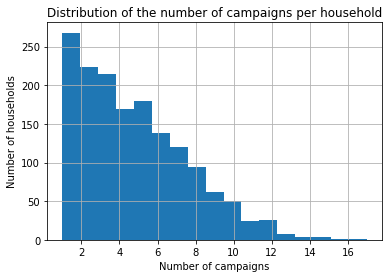

In [8]:
nbins = df_campaign_table.groupby(by = 'household_key').CAMPAIGN.count().max()
df_campaign_table.groupby(by = 'household_key').CAMPAIGN.count().hist(bins = nbins)
plt.title('Distribution of the number of campaigns per household')
plt.xlabel('Number of campaigns')
plt.ylabel('Number of households')
plt.show()

In [9]:
print('Mean number of campaigns:', df_campaign_table.groupby(by = 'household_key').CAMPAIGN.count().mean())
print('Median number of campaigns:', df_campaign_table.groupby(by = 'household_key').CAMPAIGN.count().median())
print('Max number of campaigns:', df_campaign_table.groupby(by = 'household_key').CAMPAIGN.count().max())
print('25% of the households have benefited from', df_campaign_table.groupby(by = 'household_key').CAMPAIGN.count().quantile(q = 0.25),
      'campaigns or less.')
print('75% of the households have benefited from', df_campaign_table.groupby(by = 'household_key').CAMPAIGN.count().quantile(q = 0.75),
      'campaigns or less.')
print('95% of the households have benefited from', df_campaign_table.groupby(by = 'household_key').CAMPAIGN.count().quantile(q = 0.95),
      'campaigns or less.')

Mean number of campaigns: 4.55050505050505
Median number of campaigns: 4.0
Max number of campaigns: 17
25% of the households have benefited from 2.0 campaigns or less.
75% of the households have benefited from 6.0 campaigns or less.
95% of the households have benefited from 10.0 campaigns or less.


## Causal data

In [11]:
df_causal = pd.read_csv('dunnhumby/causal_data.csv')

In [12]:
df_causal.head()

,PRODUCT_ID,STORE_ID,WEEK_NO,display,mailer
0,26190,286,70,0,A
1,26190,288,70,0,A
2,26190,289,70,0,A
3,26190,292,70,0,A
4,26190,293,70,0,A


Let's define two dict for the code meaning of display and mailer.

In [13]:
display_dict = {0:'Not on Display', 1:'Store Front', 2:'Store Rear', 3:'Front End Cap',
                4:'Mid-Aisle End Cap', 5:'Read End Cap' ,6:'Side-Aisle End Cap', 7:'In-Aisle' ,
                9:'Secondary Location Display' ,'A':'In-Shelf' }
mailer_dict = {0:'Not on ad', 'A':'Interior page feature', 'C':'Interior page line item', 
              'D':'Front page feature', 'F':'Back page feature', 'H':'Wrap front feature',
              'J':'Wrap interior coupon', 'L':'Wrap back feature', 'P':'Interior page coupon',
              'X':'Free on interior page', 'Z':'Free on front page, back page or wrap'}

## Coupon redemption

In [14]:
df_coupon_redempt = pd.read_csv('dunnhumby/coupon_redempt.csv')

In [15]:
df_coupon_redempt.head()

,household_key,DAY,COUPON_UPC,CAMPAIGN
0,1,421,10000085364,8
1,1,421,51700010076,8
2,1,427,54200000033,8
3,1,597,10000085476,18
4,1,597,54200029176,18


## Coupon

In [16]:
df_coupon = pd.read_csv('dunnhumby/coupon.csv')

In [17]:
df_coupon.head()

,COUPON_UPC,PRODUCT_ID,CAMPAIGN
0,10000089061,27160,4
1,10000089064,27754,9
2,10000089073,28897,12
3,51800009050,28919,28
4,52100000076,28929,25


Let's study how many coupons were distributed for each campaign.

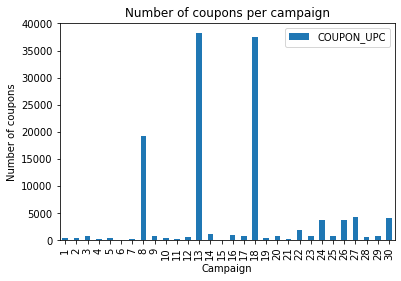

In [18]:
df_coupon.groupby(by = 'CAMPAIGN').count().plot.bar(y = 'COUPON_UPC')
plt.xlabel('Campaign')
plt.ylabel('Number of coupons')
plt.title('Number of coupons per campaign')
plt.show()

We notice there are definetely some campaigns with way more coupons than others. Is this related to the type of campaign?

## Demographics

In [19]:
df_demo = pd.read_csv('dunnhumby/hh_demographic.csv')

In [20]:
print(df_demo.head(20))
df_demo["AGE_DESC"].unique()

   AGE_DESC MARITAL_STATUS_CODE INCOME_DESC   HOMEOWNER_DESC  \
0       65+                   A      35-49K        Homeowner   
1     45-54                   A      50-74K        Homeowner   
2     25-34                   U      25-34K          Unknown   
3     25-34                   U      75-99K        Homeowner   
4     45-54                   B      50-74K        Homeowner   
5       65+                   B   Under 15K        Homeowner   
6     45-54                   A    100-124K        Homeowner   
7     35-44                   B      15-24K          Unknown   
8     25-34                   A      75-99K           Renter   
9     45-54                   A      75-99K        Homeowner   
10    35-44                   U      50-74K          Unknown   
11    45-54                   U      25-34K  Probable Renter   
12    35-44                   B      35-49K        Homeowner   
13    35-44                   A    125-149K        Homeowner   
14    45-54                   U   Under 

array(['65+', '45-54', '25-34', '35-44', '19-24', '55-64'], dtype=object)

## Products

In [21]:
df_products = pd.read_csv('dunnhumby/product.csv')

Let's explore the product data frame and filter out anything food related. We start by looking at the column *DEPARTMENT*.

In [22]:
list_dep = np.sort(df_products["DEPARTMENT"].unique())
list_commodity = np.sort(df_products["COMMODITY_DESC"].unique())
list_sub = np.sort(df_products["SUB_COMMODITY_DESC"].unique())

frames = {}
for l in list_dep:    
    frames[l] = df_products[df_products["DEPARTMENT"].apply(lambda x : x == l)]

In [23]:
print(df_products.groupby("DEPARTMENT").count()["PRODUCT_ID"].sort_values(ascending=False))

DEPARTMENT
GROCERY            39021
DRUG GM            31529
PRODUCE             3118
COSMETICS           3011
NUTRITION           2914
MEAT                2544
MEAT-PCKGD          2427
DELI                2354
PASTRY              2149
FLORAL               938
SEAFOOD-PCKGD        563
MISC. TRANS.         490
SPIRITS              377
SEAFOOD              369
GARDEN CENTER        128
RESTAURANT           102
MISC SALES TRAN       88
SALAD BAR             48
COUP/STR & MFG        39
TRAVEL & LEISUR       28
FROZEN GROCERY        23
KIOSK-GAS             16
                      15
CHEF SHOPPE           14
RX                     9
CNTRL/STORE SUP        4
POSTAL CENTER          3
DAIRY DELI             3
TOYS                   3
VIDEO RENTAL           3
GM MERCH EXP           3
PHOTO                  2
DELI/SNACK BAR         2
PROD-WHS SALES         2
GRO BAKERY             2
CHARITABLE CONT        2
AUTOMOTIVE             2
VIDEO                  2
PORK                   1
ELECT &PLUMBIN

Let's observe the biggest categories and see whats in it.

In [24]:
frames["GROCERY"]["COMMODITY_DESC"].unique()

array(['FRZN ICE', 'FRUIT - SHELF STABLE', 'COOKIES/CONES',
       'SPICES & EXTRACTS', 'PNT BTR/JELLY/JAMS',
       'ICE CREAM/MILK/SHERBTS', 'AIR CARE', 'CHEESE', 'SHORTENING/OIL',
       'COFFEE', 'PAPER HOUSEWARES', 'BAKED BREAD/BUNS/ROLLS',
       'VEGETABLES - SHELF STABLE', 'HISPANIC', 'DINNER MXS:DRY',
       'CONDIMENTS/SAUCES', 'FRZN VEGETABLE/VEG DSH', 'BAKING NEEDS',
       'FRZN FRUITS', 'HOUSEHOLD CLEANG NEEDS', 'FD WRAPS/BAGS/TRSH BG',
       'DRY MIX DESSERTS', 'PICKLE/RELISH/PKLD VEG', 'BAKING MIXES',
       'FLUID MILK PRODUCTS', 'SOUP', 'BAKED SWEET GOODS',
       'DRY BN/VEG/POTATO/RICE', 'FACIAL TISS/DNR NAPKIN', 'FROZEN PIZZA',
       'EGGS', 'REFRGRATD DOUGH PRODUCTS', 'HOT CEREAL', 'COLD CEREAL',
       'SUGARS/SWEETNERS', 'SEAFOOD - SHELF STABLE', 'CANNED JUICES',
       'BAG SNACKS', 'BEANS - CANNED GLASS & MW', 'CRACKERS/MISC BKD FD',
       'CONVENIENT BRKFST/WHLSM SNACKS', 'SOFT DRINKS', 'BUTTER',
       'FRZN MEAT/MEAT DINNERS', 'WATER - CARBONATED/FLVRD D

As expected the category **Grocery** is all over the place and contains basically anything what can be bought in a grocery store. The category is not really helpful and we have to check the sub categories.

Lets check **Drug Gm** next and see, if there is anythin food-related in it.

In [25]:
frames["DRUG GM"]["COMMODITY_DESC"].unique()

array(['VITAMINS', 'MAGAZINE', 'DIETARY AID PRODUCTS',
       'STATIONERY & SCHOOL SUPPLIES', 'COLD AND FLU', 'BABY HBC',
       'SOAP - LIQUID & BAR', 'KITCHEN GADGETS', 'CANDY - PACKAGED',
       'HAIR CARE PRODUCTS', 'CANDY - CHECKLANE', 'SHAVING CARE PRODUCTS',
       'FIRST AID PRODUCTS', 'NEWSPAPER', 'INSECTICIDES',
       'ELECTRICAL SUPPPLIES', 'IRONING AND CHEMICALS', 'ANALGESICS',
       'HOSIERY/SOCKS', 'BATTERIES', 'BOOKSTORE',
       'SPRING/SUMMER SEASONAL', 'CHARCOAL AND LIGHTER FLUID',
       'HAND/BODY/FACIAL PRODUCTS', 'ORAL HYGIENE PRODUCTS',
       'INFANT FORMULA', 'DEODORANTS', 'FEMININE HYGIENE',
       'COFFEE FILTERS', 'BROOMS AND MOPS',
       'GREETING CARDS/WRAP/PARTY SPLY', 'HARDWARE SUPPLIES', 'ANTACIDS',
       'CIGARETTES', 'BABY FOODS', 'SINUS AND ALLERGY',
       'INFANT CARE PRODUCTS', 'TOBACCO OTHER',
       'FILM AND CAMERA PRODUCTS', 'PLASTIC HOUSEWARES',
       'FOOT CARE PRODUCTS', 'SHOE CARE', 'FIREWORKS', 'SUNTAN',
       'CANDLES/ACCESSORIES',

* 'DIETARY AID PRODUCTS' (candy bar, novelty candy, candy bags-chocolate)
* 'CANDY - PACKAGED'
* 'CANDY - CHECKLANE'
* 'INFANT FORMULA'
* 'BABY FOODS' 
* 'DOMESTIC GOODS'
* 'NATURAL HBC' (novelty candy)

After looking at the commodities individually , these do have some food related stuff in them.

In the end the following *DEPARTMENT* values are food related. There still some a lot of non food items. We have to filter them out.

In [26]:
list_dep_food = ["GROCERY", "DRUG GM", "PRODUCE", "NUTRITION", "MEAT","MEAT-PCKGD","DELI","PASTRY", "SEAFOOD-PCKGD", "SEAFOOD", 
                 "RESTAURANT", "MISC SALES TRAN", "SALAD BAR", "TRAVEL & LEISUR", "FROZEN GROCERY", "CHEF SHOPPE", "DAIRY DELI", 
                 "GM MERCH EXP", "DELI/SNACK BAR", "GRO BAKERY", "PORK", "MEAT-WHSE"]
non_food = ["COSMETICS", "FLORAL", "CHARITABLE CONT", "MISC. TRANS.", "SPIRITS", "GARDEN CENTER", 
            "COUP/STR & MFG", "KIOSK-GAS", "RX", "CNTRL/STORE SUP", "POSTAL CENTER", "TOYS", 
            "VIDEO RENTAL", "PHOTO", "PROD-WHS SALES", "CHARITABLE CONT", "AUTOMOTIVE", "VIDEO", 
            "ELECT &PLUMBING","HOUSEWARES", "PHARMACY SUPPLY", "HBC", " "]
print(list_dep_food)

['GROCERY', 'DRUG GM', 'PRODUCE', 'NUTRITION', 'MEAT', 'MEAT-PCKGD', 'DELI', 'PASTRY', 'SEAFOOD-PCKGD', 'SEAFOOD', 'RESTAURANT', 'MISC SALES TRAN', 'SALAD BAR', 'TRAVEL & LEISUR', 'FROZEN GROCERY', 'CHEF SHOPPE', 'DAIRY DELI', 'GM MERCH EXP', 'DELI/SNACK BAR', 'GRO BAKERY', 'PORK', 'MEAT-WHSE']


In [28]:
df_food_dep = df_products[df_products["DEPARTMENT"].apply(lambda x : x in list_dep_food)]
df_meat_dep = df_food_dep[df_food_dep["COMMODITY_DESC"].str.contains("MEAT")]
df_fish_dep = df_food_dep[df_food_dep["COMMODITY_DESC"].str.contains("FISH")]
np.sort(df_food_dep["COMMODITY_DESC"].unique())

array(['(CORP USE ONLY)', 'ADULT INCONTINENCE', 'AIR CARE', 'ANALGESICS',
       'ANTACIDS', 'APPAREL', 'APPLES', 'AUDIO/VIDEO PRODUCTS',
       'AUTOMOTIVE PRODUCTS', 'BABY FOODS', 'BABY HBC', 'BABYFOOD',
       'BACON', 'BAG SNACKS', 'BAKED BREAD/BUNS/ROLLS',
       'BAKED SWEET GOODS', 'BAKERY PARTY TRAYS', 'BAKING',
       'BAKING MIXES', 'BAKING NEEDS', 'BATH TISSUES', 'BATTERIES',
       'BEANS - CANNED GLASS & MW', 'BEEF', 'BEERS/ALES', 'BERRIES',
       'BEVERAGE', 'BIRD SEED', 'BLEACH', 'BOOKSTORE', 'BOTTLE DEPOSITS',
       'BREAD', 'BREAKFAST SAUSAGE/SANDWICHES', 'BREAKFAST SWEETS',
       'BROCCOLI/CAULIFLOWER', 'BROOMS AND MOPS', 'BULK FOODS', 'BUTTER',
       'CAKES', 'CANDLES/ACCESSORIES', 'CANDY - CHECKLANE',
       'CANDY - PACKAGED', 'CANNED JUICES', 'CANNED MILK', 'CARROTS',
       'CAT FOOD', 'CAT LITTER', 'CEREAL/BREAKFAST',
       'CHARCOAL AND LIGHTER FLUID', 'CHEESE', 'CHEESES', 'CHICKEN',
       'CHICKEN/POULTRY', 'CHIPS&SNACKS', 'CHRISTMAS  SEASONAL',
       '

In [29]:
list_food_com = ['APPLES', 'BABY FOODS', 'BABYFOOD',
       'BAG SNACKS', 'BAKED BREAD/BUNS/ROLLS',
       'BAKED SWEET GOODS', 'BAKERY PARTY TRAYS', 'BAKING',
       'BAKING MIXES', 'BAKING NEEDS',
       'BEANS - CANNED GLASS & MW', 'BEEF', 'BEERS/ALES', 'BERRIES',
       'BEVERAGE',
       'BREAD', 'BREAKFAST SAUSAGE/SANDWICHES', 'BREAKFAST SWEETS',
       'BROCCOLI/CAULIFLOWER', 'BULK FOODS', 'BUTTER',
       'CAKES', 'CANDY - CHECKLANE',
       'CANDY - PACKAGED', 'CANNED JUICES', 'CANNED MILK', 'CARROTS', 'CEREAL/BREAKFAST',
         'CHEESE', 'CHEESES', 'CHICKEN',
       'CHICKEN/POULTRY', 'CHIPS&SNACKS', 'CHRISTMAS  SEASONAL',
        'CITRUS', 'COCOA MIXES', 'COFFEE', 'COFFEE SHOP', 'COFFEE SHOP SWEET GOODS&RETAIL',
       'COLD CEREAL', 'CONDIMENTS', 'CONDIMENTS/SAUCES', 'CONVENIENT BRKFST/WHLSM SNACKS', 'COOKIES',
       'COOKIES/CONES', 'CORN', 'CRACKERS/MISC BKD FD', 'DELI MEATS',
       'DELI SPECIALTIES (RETAIL PK)', 'DELI SUPPLIES', 'DINNER MXS:DRY',
       'DINNER SAUSAGE', 'DOMESTIC GOODS',
       'DOMESTIC WINE', 'DRIED FRUIT', 'DRY BN/VEG/POTATO/RICE',
       'DRY MIX DESSERTS', 'DRY NOODLES/PASTA', 'DRY SAUCES/GRAVY',
       'DRY TEA/COFFEE/COCO MIX', 'EASTER', 'EGGS','EXOTIC GAME/FOWL',
       'FALL AND WINTER SEASONAL',
       'FITNESS&DIET', 'FLOUR & MEALS', 'FLUID MILK PRODUCTS', 'FROZEN',
       'FROZEN - BOXED(GROCERY)', 'FROZEN BREAD/DOUGH', 'FROZEN CHICKEN',
       'FROZEN MEAT', 'FROZEN PACKAGE MEAT', 'FROZEN PIE/DESSERTS',
       'FROZEN PIZZA', 'FRUIT - SHELF STABLE', 'FRZN BREAKFAST FOODS',
       'FRZN FRUITS', 'FRZN ICE', 'FRZN JCE CONC/DRNKS',
       'FRZN MEAT/MEAT DINNERS', 'FRZN NOVELTIES/WTR ICE',
       'FRZN POTATOES', 'FRZN SEAFOOD', 'FRZN VEGETABLE/VEG DSH', 'GRAPES',  'HEAT/SERVE', 'HERBS', 'HISPANIC',
       'HOME FREEZING & CANNING SUPPLY','HOT CEREAL', 'HOT DOGS',
        'ICE CREAM/MILK/SHERBTS',
       'IMPORTED WINE',
       'INFANT FORMULA',
       'ISOTONIC DRINKS',  'JUICE' , 'LAMB',
        'LIQUOR', 'LUNCHMEAT',
        'MARGARINES', 'MEAT - MISC', 'MEAT - SHELF STABLE',
       'MEAT SUPPLIES', 'MELONS', 'MILK BY-PRODUCTS', 'MISC WINE',
       'MISC. DAIRY', 'MISCELLANEOUS', 'MISCELLANEOUS CROUTONS',
       'MOLASSES/SYRUP/PANCAKE MIXS', 'MUSHROOMS', 'NATURAL HBC',
       'NATURAL VITAMINS', 'NDAIRY/TEAS/JUICE/SOD', 'NEW AGE',
        'NON-DAIRY BEVERAGES', 'NUTS',
       'OLIVES', 'ONIONS',
       'ORGANICS FRUIT & VEGETABLES', 
       'PACKAGED NATURAL SNACKS', 
       'PARTY TRAYS', 'PASTA SAUCE', 'PEARS', 'PEPPERS-ALL',
       'PICKLE/RELISH/PKLD VEG', 'PIES', 'PKG.SEAFOOD MISC',
        'PNT BTR/JELLY/JAMS', 'POPCORN', 'PORK',
        'POTATOES',
       'PREPARED FOOD',
       'PREPARED/PKGD FOODS', 'PROCESSED', 'PROD SUPPLIES',
       'PWDR/CRYSTL DRNK MX', 'QUICK SERVICE', 'REFRGRATD DOUGH PRODUCTS',
       'REFRGRATD JUICES/DRNKS', 'REFRIGERATED', 'RESTRICTED DIET',
       'RICE CAKES', 'ROLLS', 'RW FRESH PROCESSED MEAT', 'SALAD BAR',
       'SALAD MIX', 'SALADS/DIPS', 'SALD DRSNG/SNDWCH SPRD', 'SANDWICHES',
       'SEAFOOD - FROZEN', 'SEAFOOD - MISC', 'SEAFOOD - SHELF STABLE',
       'SEAFOOD-FRESH', 'SEASONAL', 'SERVICE BEVERAGE',  'SHORTENING/OIL',
        'SMOKED MEATS', 
       'SNACK NUTS', 'SNACKS', 'SNKS/CKYS/CRKR/CNDY', 'SOFT DRINKS', 'SOUP', 'SPICES & EXTRACTS',
       'SPORTS MEMORABLILIA', 'SPRING/SUMMER SEASONAL', 'SQUASH',
        'STONE FRUIT', 'SUGARS/SWEETNERS',
        'SUSHI', 'SWEET GOODS & SNACKS', 'SYRUPS/TOPPINGS',
       'TEAS', 'TOMATOES', 
       'TROPICAL FRUIT', 'TURKEY', 'UNKNOWN', 
       'VALUE ADDED FRUIT', 'VALUE ADDED VEGETABLES', 'VEAL',
       'VEGETABLES - ALL OTHERS', 'VEGETABLES - SHELF STABLE',
       'VEGETABLES SALAD', 'WAREHOUSE SNACKS', 'WATER',
       'WATER - CARBONATED/FLVRD DRINK', 'YOGURT']
print(list_food_com)

['APPLES', 'BABY FOODS', 'BABYFOOD', 'BAG SNACKS', 'BAKED BREAD/BUNS/ROLLS', 'BAKED SWEET GOODS', 'BAKERY PARTY TRAYS', 'BAKING', 'BAKING MIXES', 'BAKING NEEDS', 'BEANS - CANNED GLASS & MW', 'BEEF', 'BEERS/ALES', 'BERRIES', 'BEVERAGE', 'BREAD', 'BREAKFAST SAUSAGE/SANDWICHES', 'BREAKFAST SWEETS', 'BROCCOLI/CAULIFLOWER', 'BULK FOODS', 'BUTTER', 'CAKES', 'CANDY - CHECKLANE', 'CANDY - PACKAGED', 'CANNED JUICES', 'CANNED MILK', 'CARROTS', 'CEREAL/BREAKFAST', 'CHEESE', 'CHEESES', 'CHICKEN', 'CHICKEN/POULTRY', 'CHIPS&SNACKS', 'CHRISTMAS  SEASONAL', 'CITRUS', 'COCOA MIXES', 'COFFEE', 'COFFEE SHOP', 'COFFEE SHOP SWEET GOODS&RETAIL', 'COLD CEREAL', 'CONDIMENTS', 'CONDIMENTS/SAUCES', 'CONVENIENT BRKFST/WHLSM SNACKS', 'COOKIES', 'COOKIES/CONES', 'CORN', 'CRACKERS/MISC BKD FD', 'DELI MEATS', 'DELI SPECIALTIES (RETAIL PK)', 'DELI SUPPLIES', 'DINNER MXS:DRY', 'DINNER SAUSAGE', 'DOMESTIC GOODS', 'DOMESTIC WINE', 'DRIED FRUIT', 'DRY BN/VEG/POTATO/RICE', 'DRY MIX DESSERTS', 'DRY NOODLES/PASTA', 'DRY SAU

In [30]:
df_food_com = df_food_dep[df_food_dep["COMMODITY_DESC"].apply(lambda x : x in list_food_com)]

In the column *COMMODITY_DESC*, there are some categories, which are non ambigously only contain food items. But there are still categories like *BAKING NEEDS* which can contain non food items. We need to check their *SUB_COMMODITY_DESC* values for a description on the lowest level.

In [31]:
list_food_com_ambigious=['CHRISTMAS  SEASONAL', 'DOMESTIC GOODS','EASTER', 'FALL AND WINTER SEASONAL','HOME FREEZING & CANNING SUPPLY', 'NATURAL HBC', 'NATURAL VITAMINS','SEASONAL', 'SPORTS MEMORABLILIA', 'SPRING/SUMMER SEASONAL']

BAKING MIXES, BAKING NEEDS contains seafood?!?

Commodities to throw out (except):
* NATURAL HBC – CANDY
* NATURAL VITAMINS – PRETZELS
* SEASONAL – PUMPKINS
* SPORTS MEMORABLILIA – CANDY
* 'SPRING/SUMMER SEASONAL' – CANDY

In [32]:
df_amb_com = df_food_com[df_food_com["COMMODITY_DESC"].apply(lambda x : x in list_food_com_ambigious)]
throw_out =['MISC', 'BAKING CUPS', 'CAKE DECORS - BIRTHDAY CANDLES', 'BANDANA/SCARVES', 'FLASHLIGHTS','AS SEEN ON TV', 'MISC BULK', 'MISC SALES TRANS','PEYTON/GM EXPENSE ITEMS', 'MICROWAVE'] 

for amb in list_food_com_ambigious:
    for item in df_amb_com[df_amb_com["COMMODITY_DESC"].apply(lambda x : x == amb)]["SUB_COMMODITY_DESC"].unique():
        if not "CANDY" in item and not "PUMPKINS" in item and not "PRETZELS" in item:
            throw_out.append(item)


Final dataframe with only food.

In [33]:
df_food = df_food_com[df_food_com["SUB_COMMODITY_DESC"].apply(lambda x : not x in throw_out)]

df_food

,PRODUCT_ID,MANUFACTURER,DEPARTMENT,BRAND,COMMODITY_DESC,SUB_COMMODITY_DESC,CURR_SIZE_OF_PRODUCT
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
2,26093,69,PASTRY,Private,BREAD,BREAD:ITALIAN/FRENCH,
3,26190,69,GROCERY,Private,FRUIT - SHELF STABLE,APPLE SAUCE,50 OZ
4,26355,69,GROCERY,Private,COOKIES/CONES,SPECIALTY COOKIES,14 OZ
5,26426,69,GROCERY,Private,SPICES & EXTRACTS,SPICES & SEASONINGS,2.5 OZ
...,...,...,...,...,...,...,...
92341,18272784,103,GROCERY,National,SOFT DRINKS,SOFT DRINKS 12/18&15PK CAN CAR,144 OZ
92342,18273018,2223,GROCERY,National,BAG SNACKS,BAGGED CHEESE SNACKS,11.5 OZ
92343,18273019,2223,GROCERY,National,BAG SNACKS,BAGGED CHEESE SNACKS,11.5 OZ
92344,18273051,436,GROCERY,National,REFRGRATD JUICES/DRNKS,DAIRY CASE CITRUS PNCH/OJ SUBS,64 OZ


In [34]:
def filter_dataframe(df, word_list):
    filtered_df = df.copy()
    for word in word_list:
        filtered_df = filtered_df[~(filtered_df["DEPARTMENT"].str.contains(word) | filtered_df["COMMODITY_DESC"].str.contains(word) | filtered_df["SUB_COMMODITY_DESC"].str.contains(word))]
    return df[~df.index.isin(filtered_df.index)]

In [35]:
meat_list = ["MEAT","PORK", "BEEF", "DUCK", "CHICKEN", "POULTRY", "LAMB", "VEAL", "MUTTON", "TURKEY", "VENISON", "WILD BOAR", "BISON", "GOOSE", "RABBIT", "PHEASANT"]
seafood_list = ["HERRING", "SEAFOOD", "SEAFD","SUSHI", "FISH","SHRIMP","SALMON","TUNA","TILAPIA","ALASKA","POLLOCK","PANGASIUS","BASA","SWAI","COD","CATFISH","CRAB","CLAMS"]
sweets_snack_list = ["ROLLS", "PASTRY", "NUT","CRACKERS","DESSERT","SNKS","SNACK","CHIP", "CANDY", "ICE", "SWEET", "CHOCOLATE","POPCORN", "CAKE", "COOKIE", "PANCAKE", "BAKING", "BAKE", "PIE"]
fruits_list = ["FRUIT","APPLE", "ORANGE", "PEAR", "BANANA", "GRAPE", "BERR", "TOMATO", "LEMON", "MELON", "PEACH", "CHERR", "PINEAPPLE", "CITRUS"]
vegetable_list = ["PUMPKIN", "COLESLAW", "SPINACH", "BEAN","VEG", "POTATO", "CARROT","CORN","PEPPER", "SQUASH", "ONION", "MUSHROOM", "CUCUMBER", "CAULIFLOWER", "BROCCOLI", "OLIVE" ]
veg_animal_list = ["DAIRY","MILK","CHEESE", "YOGURT", "BUTTER", "MARGARINE", "EGG", "HONEY"]
beverage_list = ["CIDER", "BEVERAGE", "WATER", "COKE", "FANTA", "SPRITE","LIQUOR", "LEMONADE", "COCOA", "BEER", "WINE", "COFFEE", "DRINK", "TEA", "JUICE", "DRNKS", "JCE"]
condiment_list = ["SALSA","FLOUR", "DIP","OIL","SEASONING","JELLY", "JAM","SAUCE", "HERBS", "CONDIMENT", "TOPPING", "SYRUP", "DRESSING", "KETCHUP", "MAYO", "DRSNG"]
carbs_list = ["NOODLES", "PASTA", "CROUTON","RICE", "BREAD", "TOAST", "CEREAL", "OATMEAL", "DOUGH", "POTATO"]
meal_list = ["PIZZA", "RAMEN", "SANDWICH", "SALAD","SOUP","ENTREE", "DINNER", "BREAKFAST", "THAI", "ASIAN", "ITALIAN", "MEXICAN", "GERMAN", "BURRITO", "FOOD", "ORIENTAL", "DISH"]
df_meat = filter_dataframe(df_food, meat_list)
df_seafood = filter_dataframe(df_food, seafood_list)
df_sweets_snack = filter_dataframe(df_food, sweets_snack_list)
df_fruits = filter_dataframe(df_food, fruits_list)
df_vegetable = filter_dataframe(df_food, vegetable_list)
df_veg_animal = filter_dataframe(df_food, veg_animal_list)
df_beverage = filter_dataframe(df_food, beverage_list)
df_condiments = filter_dataframe(df_food, condiment_list)
df_carbs = filter_dataframe(df_food, carbs_list)
df_meals = filter_dataframe(df_food, meal_list)
df_left = df_food[~df_food.index.isin(np.concatenate((df_meat.index,df_seafood.index, df_sweets_snack.index, df_fruits.index, df_vegetable.index, df_beverage.index, df_veg_animal.index, df_condiments.index, df_carbs.index, df_meals.index)))]

In [36]:
df_left["SUB_COMMODITY_DESC"].unique()

array(['PACKAGED MIX', 'PROCESSED OTHER', 'INFANT FORMULA TODDLER',
       'INFANT FORMULA SPECIALTY', 'CORPORATE DELETES (DO NOT USE',
       'INFANT FORMULA SOY BASE', 'DIET BARS DIET LIQUID MEALS',
       'GARLIC JAR', 'MISC DIET', 'REFRIGERATED KOSHER PRODUCTS'],
      dtype=object)

## Transcation data

In [37]:
df_transaction = pd.read_csv('dunnhumby/transaction_data.csv')

In [38]:
df_transaction.head()

,household_key,BASKET_ID,DAY,PRODUCT_ID,QUANTITY,SALES_VALUE,STORE_ID,RETAIL_DISC,TRANS_TIME,WEEK_NO,COUPON_DISC,COUPON_MATCH_DISC
0,2375,26984851472,1,1004906,1,1.39,364,-0.60,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.00,1631,1,0.0,0.0
2,2375,26984851472,1,1036325,1,0.99,364,-0.30,1631,1,0.0,0.0
3,2375,26984851472,1,1082185,1,1.21,364,0.00,1631,1,0.0,0.0
4,2375,26984851472,1,8160430,1,1.50,364,-0.39,1631,1,0.0,0.0


## Join Food and Transaction

In [39]:
df_food_trans = pd.merge(df_food, df_transaction, on='PRODUCT_ID', how='left')

In [40]:
number_households = len(df_food_trans["household_key"].unique())
number_households

2501

Let's check what percentile of the households did not buy meat and seafood products at all.

In [41]:
df_meat_seafood = df_meat.append(df_seafood)
df_meat_seafood.drop_duplicates()

,PRODUCT_ID,MANUFACTURER,DEPARTMENT,BRAND,COMMODITY_DESC,SUB_COMMODITY_DESC,CURR_SIZE_OF_PRODUCT
45,27860,69,GROCERY,Private,BAKING NEEDS,PIE FILLING MINCEMEAT GLAZES,21 OZ
52,27951,69,MEAT-PCKGD,Private,DINNER SAUSAGE,FRESH,18 OZ
71,28267,69,MEAT-PCKGD,Private,DINNER SAUSAGE,FRESH,18 OZ
123,30003,397,MEAT-PCKGD,National,FROZEN MEAT,FRZN BREADED PREPARED CHICK,9 OZ
156,31493,151,GROCERY,National,FRZN MEAT/MEAT DINNERS,FRZN SS PREMIUM ENTREES/DNRS/T,10 OZ
...,...,...,...,...,...,...,...
91353,17249613,1087,GROCERY,National,FRZN SEAFOOD,FRZN BRD WHOLE FILLETS,18.2 OZ
91366,17249713,80,GROCERY,National,FRZN SEAFOOD,FRZN BRD WHOLE FILLETS,8 OZ
91534,17319084,379,DELI,National,SUSHI,SUSHI - IN STORE PREPARED,10.5 OZ
91683,17381676,4162,SEAFOOD,National,SEAFOOD - FROZEN,SEAFOOD-FRZ-RW-ALL,


In [42]:
df_meat_seafood_trans = pd.merge(df_meat_seafood, df_transaction, on='PRODUCT_ID', how='left')
number_household_meat_seafood = len(df_meat_seafood_trans["household_key"].unique())
print("Number of households who did not purchased any meat or seafood: % d" %(number_households-number_household_meat_seafood))

Number of households who did not purchased any meat or seafood:  24


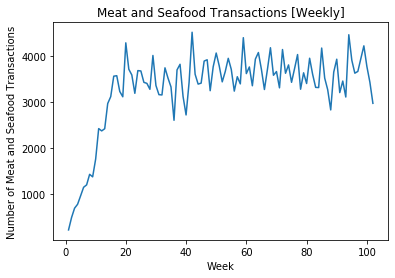

In [43]:
weekly_meat_sea = df_meat_seafood_trans.groupby("WEEK_NO").count()["PRODUCT_ID"]
weekly_trans = df_food_trans.groupby("WEEK_NO").count()["PRODUCT_ID"]
plt.plot(weekly_meat_sea)
plt.xlabel("Week")
plt.ylabel("Number of Meat and Seafood Transactions")
plt.title("Meat and Seafood Transactions [Weekly]")
plt.show()

Overall there is no upwards or downwards trend of meat and seafood transactions. But it is weird that the meat and seafood transactions rose rapidly in the first few weeks. It is likely that in the beginning not all transactions were caught. We take a look at the relation between the number of transactions and the number of meat and seafood transactions. If the rise in the beginning is only due to the fact that not all transactions were recorded, then the relation should be linear.

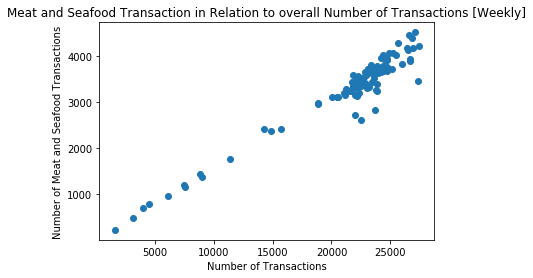

In [44]:
plt.scatter(weekly_trans, weekly_meat_sea)
plt.xlabel("Number of Transactions")
plt.ylabel("Number of Meat and Seafood Transactions")
plt.title("Meat and Seafood Transaction in Relation to overall Number of Transactions [Weekly]")
plt.show()

The relation is indeed linear.

Next we take a look at the number of households which weekly buy meat or seafood products.

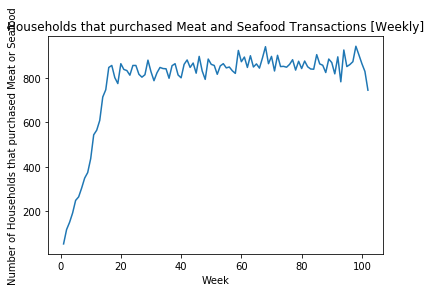

In [45]:
plt.plot(df_meat_seafood_trans.groupby("WEEK_NO")["household_key"].nunique())
plt.xlabel("Week")
plt.ylabel("Number of Households that purchased Meat or Seafood")
plt.title("Households that purchased Meat and Seafood Transactions [Weekly]")
plt.show()

The number again stays relatively stable at around 800-900. That is surprising, because the number of households which did purchase a meat product in the two years is 2475.

Let's check the number of households, which go vegetarian in a week.

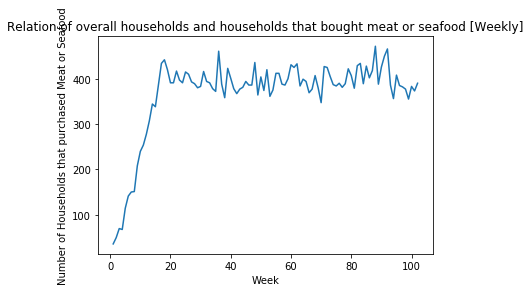

In [46]:
weekly_vege = df_food_trans.groupby("WEEK_NO")["household_key"].nunique()-df_meat_seafood_trans.groupby("WEEK_NO")["household_key"].nunique()
plt.plot(weekly_vege)
plt.xlabel("Week")
plt.ylabel("Number of Households that purchased Meat or Seafood")
plt.title("Relation of overall households and households that bought meat or seafood [Weekly]")
plt.show()

Surprisingly the number is super high considering that almost all households do not live completely vegetarian. Lets check the frequency of the meat and seafood purchases of all households.

In [47]:
house_purchase = df_meat_seafood_trans.groupby("household_key").count()["PRODUCT_ID"]
print(house_purchase)
plt.hist(weekly_house_purchase, bins=50)
plt.xlabel("Number of meat and seafood transactions")
plt.ylabel("Frequency")
plt.title("Histrogram for Meat and SEAFOOD transaction in a household")
plt.show()

household_key
1       150
2        60
3       169
4        44
5        31
       ... 
2496    306
2497    220
2498     62
2499    138
2500    139
Name: PRODUCT_ID, Length: 2477, dtype: int64


NameError: name 'weekly_house_purchase' is not defined

In [ ]:
house_purchase.sort_values().head(50)

Lets check the 